# Demonstration of Gibbs Sampler on a Nonlinear Model with 4 Parameters

In [ ]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import pandas as pd

# Configuration
np.random.seed(42)
param_names = ["m0", "m1", "m2", "m3"]
model_string = "y = m0 / (1 + exp(-m1*(x - m2))) + m3*sin(x)"
true_params = [3.0, 2.0, 5.0, 0.2]

def nonlinear_model(x, m):
    return m[0] / (1 + np.exp(-m[1]*(x - m[2]))) + m[3] * np.sin(x)

# Simulated observations
sigma_low = 0.0005
sigma_high = 10.0

x_data = np.linspace(0, 10, 800)
y_true = nonlinear_model(x_data, true_params)
y_obs_low = y_true + np.random.normal(0, sigma_low, size=len(x_data))
y_obs_high = y_true + np.random.normal(0, sigma_high, size=len(x_data))

# Gibbs Sampling parameters
n_samples = 10000
burn_in = n_samples // 2
step_sizes = [0.5, 0.2, 0.2, 0.1]
init_guess = [1.0, 1.0, 1.0, 1.0]

In [9]:
def plot_fits(x, y_true, y_obs, mean_params, label):
    plt.figure(figsize=(10, 4))
    plt.plot(x, y_true, 'k-', label='True')
    plt.plot(x, y_obs, '.', label='Observed', alpha=0.4)
    plt.plot(x, nonlinear_model(x, mean_params), 'r--', label='Inferred')
    plt.title(f'{label} Fit')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def triangle_plot(data, param_names, true_params, inferred_params, label):
    if  isinstance(data, np.ndarray):
        df = pd.DataFrame(data, columns=param_names)
    else:
        df = az.extract(data, var_names=param_names).to_dataframe()[param_names]
    
    g = sns.PairGrid(df, vars=param_names, corner=True)
    g.map_lower(sns.kdeplot, levels=5, fill=False)
    g.map_diag(sns.kdeplot, fill=True)
    for i, p in enumerate(param_names):
        ax = g.axes[i, i]
        ax.axvline(true_params[i], color='k', linestyle='-')
        ax.axvline(inferred_params[i], color='r', linestyle='--')

    plt.suptitle(label + " - Triangle Plot", y=1.02)
    plt.show()
    
def print_summary(model_string, true_vals, inferred_vals, label):
    print(f"--- {label} Summary ---")
    print(f"{model_string}")

    print(f"{'Param':<5} {'True':>10} {'Inferred':>10} {'Error':>10}")
    for name, t, p in zip(param_names, true_vals, inferred_vals):
        print(f"{name:<5} {t:10.4f} {p:10.4f} {p - t:10.4f}")

In [10]:
def log_likelihood(p, x, y_obs, sigma):
    y_model = nonlinear_model(x, p)
    return -0.5 * np.sum(((y_obs - y_model) / sigma) ** 2)

def gibbs_sampler(x, y_obs, sigma, init_params, num_samples, step_size):
    samples = np.zeros((num_samples, len(init_params)))
    current = np.array(init_params)
    for i in range(num_samples):
        for j in range(len(init_params)):
            proposal = current.copy()
            proposal[j] += np.random.normal(0, step_size[j])
            if np.random.rand() < np.exp(
                log_likelihood(proposal, x, y_obs, sigma) - log_likelihood(current, x, y_obs, sigma)
            ):
                current[j] = proposal[j]
        samples[i, :] = current
    return samples

## 🔵 Inference on Low Noise Data (σ = 0.01)

--- Low Noise Summary ---
y = m0 / (1 + exp(-m1*(x - m2))) + m3*sin(x)
Param       True   Inferred      Error
m0        3.0000     3.0001     0.0001
m1        2.0000     1.9999    -0.0001
m2        5.0000     5.0001     0.0001
m3        0.2000     0.1999    -0.0001


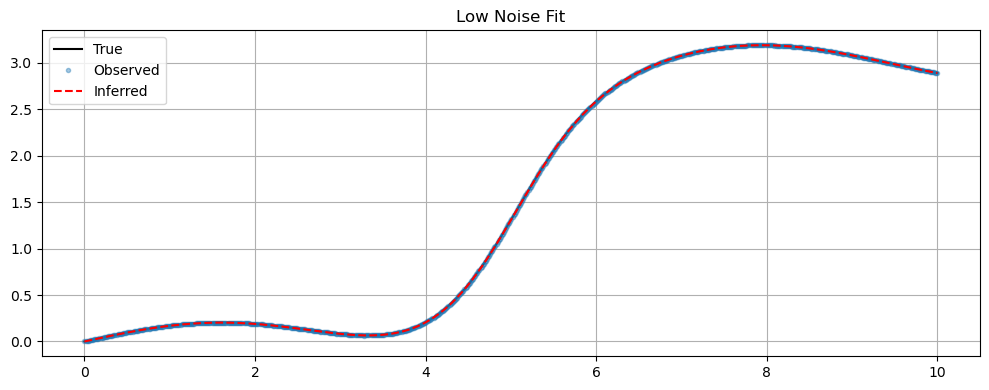

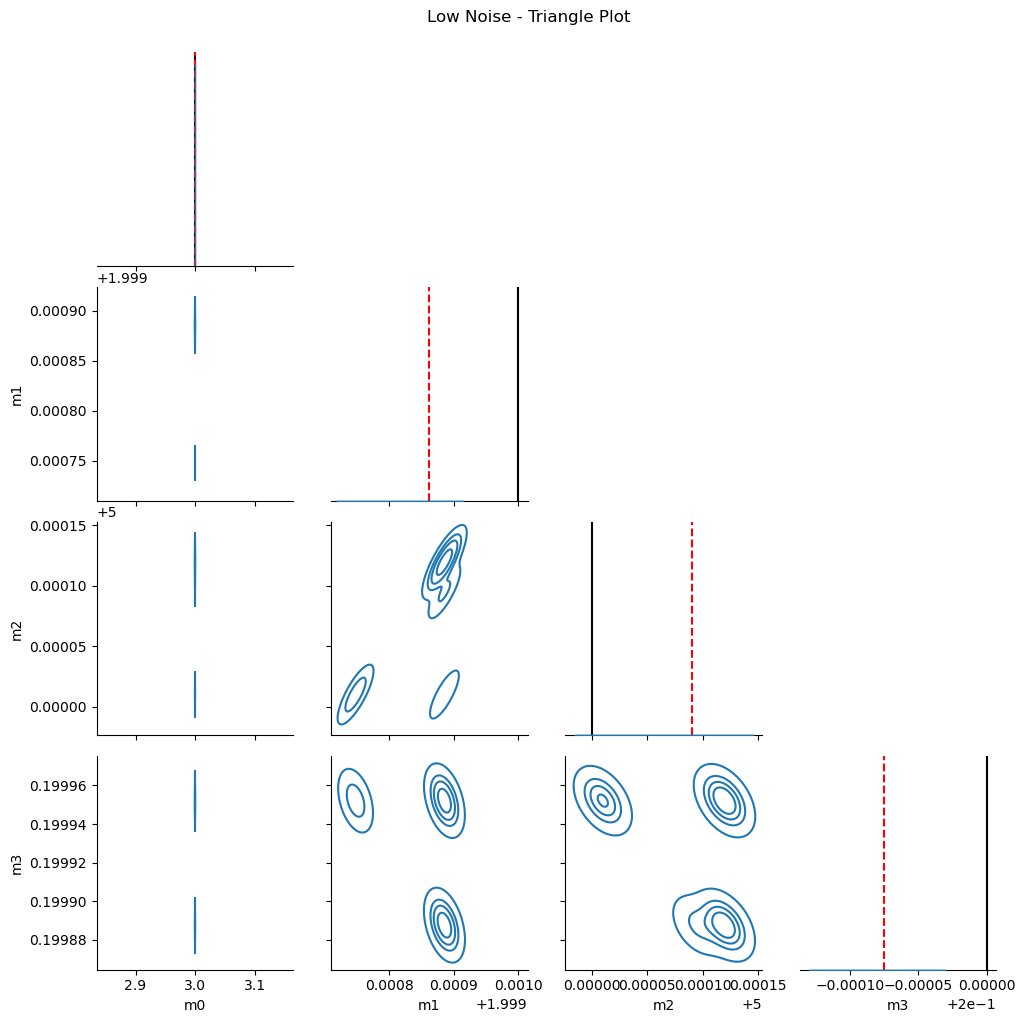

In [11]:
samples_low = gibbs_sampler(x_data, y_obs_low, sigma_low, init_guess, n_samples, step_sizes)
posterior_low = samples_low[burn_in:]
mean_low = np.mean(posterior_low, axis=0)

print_summary(model_string, true_params, mean_low, "Low Noise")
plot_fits(x_data, y_true, y_obs_low, mean_low, "Low Noise")
triangle_plot(posterior_low, param_names, true_params, mean_low, "Low Noise")


## 🔴 Inference on High Noise Data (σ = 2.0)

--- High Noise Summary ---
y = m0 / (1 + exp(-m1*(x - m2))) + m3*sin(x)
Param       True   Inferred      Error
m0        3.0000     2.8632    -0.1368
m1        2.0000    16.2010    14.2010
m2        5.0000     3.2989    -1.7011
m3        0.2000     1.8076     1.6076


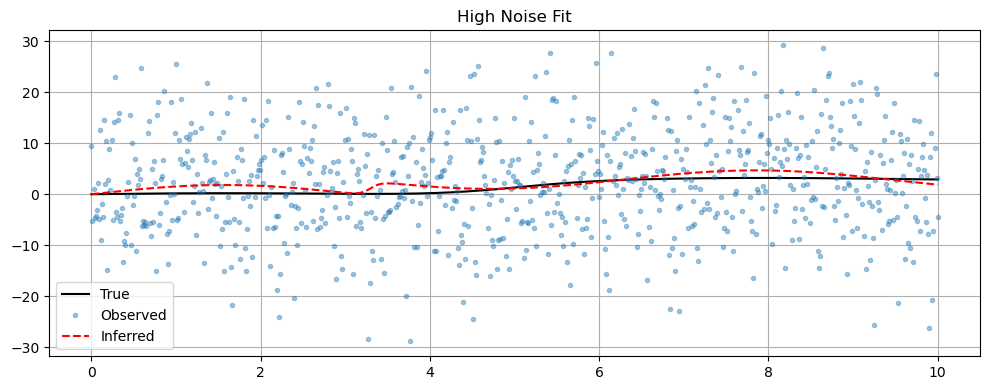

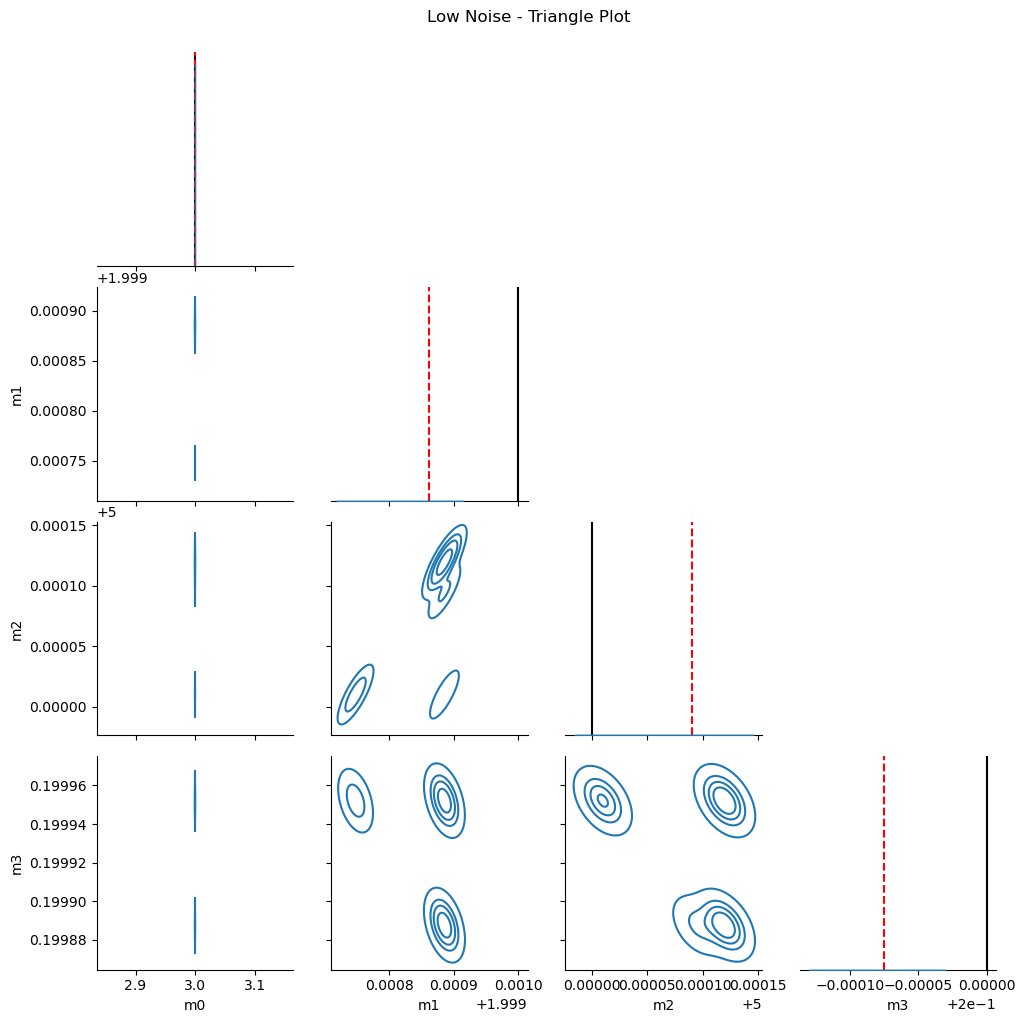

In [12]:
# samples_low = gibbs_sampler(x_data, y_obs_low, sigma_low, init_guess, n_samples, step_sizes)
# posterior_low = samples_low[burn_in:]
# mean_low = np.mean(posterior_low, axis=0)
samples_high = gibbs_sampler(x_data, y_obs_high, sigma_high, init_guess, n_samples, step_sizes)
posterior_high = samples_high[burn_in:]
mean_high = np.mean(posterior_high, axis=0)

print_summary(model_string, true_params, mean_high, "High Noise")
plot_fits(x_data, y_true, y_obs_high, mean_high, "High Noise")
triangle_plot(posterior_low, param_names, true_params, mean_low, "Low Noise")